# Text Mining Project

### NOVA IMS MT Metrics Shared Task

**Group members:**
- Lorenzo Pigozzi	--- m20200745
- Davide Farinati
- Antonio
- Luis Reis

**Objective**

The goal of this project is to develop a metric that predicts the quality of a translation using the reference. 

\
**Evaluation**\
Your metric should correlate well with the existing quality assessments that you have in the above corpus.
The one that we have so far are just the training sets, we will have a test set without the z-score, average score and annotators.
Produce our own metric that will be compared with the existing ones.


<a class="anchor" id="0.1"></a>
# **Table of Contents**

1.	[Importing libraries and corpora](#1)   
2.	[Brief Exploratory data analysis (EDA)](#2)       
3.	[Baseline](#3)     
 3.1. [Pre-processing](#3.1.)\
 3.2. [Feature Extraction](#3.2.)\
 3.3. [Model](#3.3.)\
 3.4. [Evaluation](#3.4.)

**Notes**\
Sklearn:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

## 1. Importing libraries and corpora <a class="anchor" id="1"></a>

In [37]:
# general libraries
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# word's preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from nltk.translate.bleu_score import sentence_bleu
from bs4 import BeautifulSoup
import string

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing the corpora
cs_en = pd.read_csv('corpus\cs-en\scores.csv')
de_en = pd.read_csv('corpus\de-en\scores.csv')
ru_en = pd.read_csv('corpus\scores_ru-en.csv')
zh_en = pd.read_csv('corpus\zh-en\scores.csv')
en_fi = pd.read_csv('corpus\en-fi\scores.csv')
en_zh = pd.read_csv('corpus\en-zh\scores.csv')

## 2. Brief Exploratory Data Analysis <a class="anchor" id="2"></a>

In [3]:
en_fi.head()

,source,reference,translation,z-score,avg-score,annotators
0,"You can turn yourself into a pineapple, a dog ...","Voit muuttaa itsesi ananasta, koirasta tai Roy...","Voit muuttaa itsesi ananakseksi, koiraksi tai ...",-0.286195,34.20,5
1,Also shot were three men: two 29-year-olds and...,Myös ammuttiin kolme miestä: kaksi 29-vuotiait...,Myös kolmea miestä ammuttiin: kahta 29-vuotias...,0.547076,58.40,5
2,The information is stored at the cash register...,Tiedot tallennetaan kassakoneisiin joka tapauk...,Tiedot kuitenkin tallentuvat kassoilla joka ta...,1.122476,74.60,5
3,Xinhua says that there were traces of hydrochl...,"Xinhua kertoo, että Xinyin näytteestä oli sunn...","Xinhua kertoo, että Xinyin sunnuntaina antamas...",0.383095,53.60,5
4,"MacDonald, who was brought on board CBC's comm...",Voitaisiin kuulla CBD: n kommenttitiimin toimi...,"MacDonaldin, joka tuli CBC:n selostajatiimiin ...",-0.493065,32.25,4


**Notes**\
All the the Dataframes imported have 6 columns:
- Sources: the original text in the original language
- Reference: The correct translation
- Translation: the translation that we will evaluate
- Z-score: score of the translation normalized
- Avg-score: score of the translation from 0 to 100
- Annotators: number of annotators

In [4]:
print('Total number of translations : ',len(cs_en) + len(de_en) + len(ru_en) + len(zh_en) + len(en_fi) + len(en_zh) )

Total number of translations :  94657


## 3. Baseline <a class="anchor" id="3"></a>

**Idea**\
Splitting the problem in 3:
- estimate the translations from other languages to English
- estimate the translations from English to Finnish
- estimate the translations from English to Chinese

\
Reason:\
Proably going forward we will need to have different preprocessing for English and for the other 2 languages

### 3.1. Pre-processing <a class="anchor" id="3.1."></a>

In [5]:
cs_en.head()

,source,reference,translation,z-score,avg-score,annotators
0,Uchopíte pak zbraň mezi své předloktí a rameno...,You will then grab the weapon between your for...,You then grasp the gun between your forearm an...,-0.675383,60.000000,3
1,"Ale je-li New York změna, pak je to také znovu...","But if New York is changed, then it's also a r...","But if New York is change, it is also reinvent...",-0.829403,44.000000,2
2,"Dlouho a intenzivně jsem během léta přemýšlel,...",I have been thinking over and over again over ...,I have thought long and hard over the course o...,0.803185,96.500000,2
3,"Najdou si jiný způsob, jak někde podvádět.",They find another way to cheat somewhere.,They will find another way how to defraud others.,0.563149,90.500000,2
4,Zpráva o výměně v čele prezidentovy administra...,The report on the replacement of the president...,The news of the replacement at the top of the ...,0.021549,74.666667,3


In [6]:
# selecting the necessary variables for the baseline
cs_en = cs_en[['reference','translation','avg-score']]
de_en = de_en[['reference','translation','avg-score']]
ru_en = ru_en[['reference','translation','avg-score']]
zh_en = zh_en[['reference','translation','avg-score']]

In [7]:
cs_en.head()

,reference,translation,avg-score
0,You will then grab the weapon between your for...,You then grasp the gun between your forearm an...,60.000000
1,"But if New York is changed, then it's also a r...","But if New York is change, it is also reinvent...",44.000000
2,I have been thinking over and over again over ...,I have thought long and hard over the course o...,96.500000
3,They find another way to cheat somewhere.,They will find another way how to defraud others.,90.500000
4,The report on the replacement of the president...,The news of the replacement at the top of the ...,74.666667


In [8]:
# joining the 4 datasets with English translations
df = pd.concat([cs_en, de_en, ru_en, zh_en], axis = 0).reset_index(drop=True)

In [9]:
# a few options for preprocessing
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [10]:
# function to clean the text
def clean(text_list, lemmatize=False):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    updates = []
    for j in tqdm(range(len(text_list))):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA AND PUNCTUATION
        text = re.sub("[^a-z]", ' ', text)
        
        #REMOVE TAGS
        text = BeautifulSoup(text).get_text()
        
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        updates.append(text)
        
    return updates

# function to update the dataframe with the cleaned text
def update_df(dataframe, list_updated, variable):
    dataframe.update(pd.DataFrame({variable: list_updated}))

In [11]:
# cleaning the references
updates_reference = clean(df["reference"], lemmatize = True)
update_df(df, updates_reference, "reference")

<ipython-input-10-6ecb4a442cb3>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j in tqdm(range(len(text_list))):


In [12]:
# cleaning the translations
updates_translation = clean(df["translation"], lemmatize = True)
update_df(df, updates_translation, "translation")
df.head()

<ipython-input-10-6ecb4a442cb3>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j in tqdm(range(len(text_list))):


,reference,translation,avg-score
0,you will then grab the weapon between your for...,you then grasp the gun between your forearm an...,60.000000
1,but if new york is changed then it s also a re...,but if new york is change it is also reinvention,44.000000
2,i have been thinking over and over again over ...,i have thought long and hard over the course o...,96.500000
3,they find another way to cheat somewhere,they will find another way how to defraud others,90.500000
4,the report on the replacement of the president...,the news of the replacement at the top of the ...,74.666667


### 3.2. Train, Development and Test sets <a class="anchor" id="3.2."></a>

In [13]:
## train-dev-test split
train, test = train_test_split(df, test_size=0.2, shuffle = True, random_state = 7)
test, dev = train_test_split(test, test_size=0.5, shuffle = True, random_state = 7)

In [16]:
dev_encoded_reference

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# Metrics

### BLEU
**How to evauate a translation: BLEU**\
One thing you might do is look at each word in the output sentence and assign it a score of 1 if it shows up in any of the reference sentences and 0 if it doesn’t. Then, to normalize that count so that it’s always between 0 and 1, you can divide the number of words that showed up in one of the reference translations by the total number of words in the output sentence. This gives us a measure called unigram precision.\
https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213

\
**A Gentle Introduction to Calculating the BLEU Score for Text in Python**
https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

\
**NLP Metrics Made Simple: The BLEU Score**\
https://towardsdatascience.com/nlp-metrics-made-simple-the-bleu-score-b06b14fbdbc1


\
"A popular metric is BLEU, which counts the sequences of words in the candidate that also appear in the reference (the BLEU score is very similar to precision)."\
https://ai.googleblog.com/2020/05/evaluating-natural-language-generation.html#:~:text=BLEURT%20is%20a%20novel,%20machine,ratings%20provided%20by%20the%20user.

In [44]:
## Example
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

1.0


In [18]:
# cumulative BLEU score
def avg_bleu_score(df, ngram = 'unigram'):
    bleu_scores = []
    for i in df.index:
        reference = []
        reference.append(df['reference'][i].split(' '))
        translation = df['translation'][i].split(' ')
        if ngram == 'bigram':
            bleu_scores.append(sentence_bleu(reference, translation, weights=(0.5, 0.5, 0, 0)))
        elif ngram == '3-gram':
            bleu_scores.append(sentence_bleu(reference, translation, weights=(0.33, 0.33, 0.33, 0)))
        elif ngram == '4-gram':
            bleu_scores.append(sentence_bleu(reference, translation, weights=(0.25, 0.25, 0.25, 0.25)))
        else:
            bleu_scores.append(sentence_bleu(reference, translation))
    return pd.Series(bleu_scores).mean(), bleu_scores

In [55]:
# calculating the scores
bleu_score_unigram, unigram_scores = avg_bleu_score(train)
bleu_score_bigram, bigram_scores = avg_bleu_score(train, ngram = 'bigram')
bleu_score_3gram, trigram_scores = avg_bleu_score(train, ngram = '3-gram')
bleu_score_4gram, fourgram_scores = avg_bleu_score(train, ngram = '4-gram')

In [56]:
grams = ['unigram', 'bigram', '3-gram', '4-gram']
bleu_scores = [bleu_score_unigram, bleu_score_bigram, bleu_score_3gram, bleu_score_4gram]
for i in range(len(grams)):
    print('Average BLEU score for', grams[i] ,' :', bleu_scores[i])

Average BLEU score for unigram  : 0.2076622654785226
Average BLEU score for bigram  : 0.4090547842910233
Average BLEU score for 3-gram  : 0.297260902239954
Average BLEU score for 4-gram  : 0.2076622654785226


In [86]:
# checking the correlation with the avg-score
bleu_score_relation = pd.concat([train.reset_index(drop=True), pd.Series(unigram_scores)], axis = 1).iloc[:, -2:]
pearson_unigram = bleu_score_relation.corr(method='pearson').iloc[1:2,:1].values[0][0]
bleu_score_relation = pd.concat([train.reset_index(drop=True), pd.Series(bigram_scores)], axis = 1).iloc[:, -2:]
pearson_bigram = bleu_score_relation.corr(method='pearson').iloc[1:2,:1].values[0][0]
bleu_score_relation = pd.concat([train.reset_index(drop=True), pd.Series(trigram_scores)], axis = 1).iloc[:, -2:]
pearson_3gram = bleu_score_relation.corr(method='pearson').iloc[1:2,:1].values[0][0]
bleu_score_relation = pd.concat([train.reset_index(drop=True), pd.Series(fourgram_scores)], axis = 1).iloc[:, -2:]
pearson_4gram = bleu_score_relation.corr(method='pearson').iloc[1:2,:1].values[0][0]

In [88]:
pearson_grams = [pearson_unigram, pearson_bigram, pearson_3gram, pearson_4gram]
for i in range(len(grams)):
    print('Pearson relations among Bleu and score', grams[i] ,' :', pearson_grams[i])

Pearson relations among Bleu and score unigram  : 0.2556770746721379
Pearson relations among Bleu and score bigram  : 0.3120262696218851
Pearson relations among Bleu and score 3-gram  : 0.2856859598242893
Pearson relations among Bleu and score 4-gram  : 0.2556770746721379


### ROUGE



**The Ultimate Performance Metric in NLP**\
https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460
http://www.ccs.neu.edu/home/vip/teach/DMcourse/5_topicmodel_summ/notes_slides/What-is-ROUGE.pdf

**How to evauate a translation: Rouge**

ROUGE-N measures the number of matching ‘n-grams’ between our model-generated text and a ‘reference’. Once we have decided which N to use — we now decide on whether we’d like to calculate the ROUGE recall, precision, or F1 score.\
ROUGE-L measures the longest common subsequence (LCS) between our model output and reference. All this means is that we count the longest sequence of tokens that is shared between both

In [28]:
# !pip install rouge
from rouge import Rouge

 #### Example:

In [29]:
model_out = "he began by starting a five person war cabinet and included chamberlain as lord president of the council"
reference = "he began his premiership by forming a five-man war cabinet which included chamberlain as lord president of the council"
rouge = Rouge()

**How to evauate a translation: Rouge**\
The get_scores method returns three metrics, ROUGE-N using a unigram (ROUGE-1) and a bigram (ROUGE-2) — and ROUGE-L.
For each of these, we receive the F1 score f, precision p, and recall r.

In [30]:
scores=rouge.get_scores(model_out, reference)
print(scores)

[{'rouge-1': {'f': 0.7567567517604091, 'p': 0.7777777777777778, 'r': 0.7368421052631579}, 'rouge-2': {'f': 0.514285709289796, 'p': 0.5294117647058824, 'r': 0.5}, 'rouge-l': {'f': 0.7567567517604091, 'p': 0.7777777777777778, 'r': 0.7368421052631579}}]


#### Real:

In [31]:
references =df['reference'].to_list()
translation =df['translation'].to_list()

In [32]:
print(len(references))
print(len(translation))

7769
7769


In [33]:
scores = rouge.get_scores(references, translation, avg=True,ignore_empty=True)
scores

{'rouge-1': {'f': 0.5965808610496935,
  'p': 0.6064682072708397,
  'r': 0.595974673319304},
 'rouge-2': {'f': 0.33425206133048524,
  'p': 0.3400030535144087,
  'r': 0.33362576720674053},
 'rouge-l': {'f': 0.5500085676327428,
  'p': 0.5632367239487576,
  'r': 0.5441727394500053}}

## BLEURT
### Bilingual Evaluation Understudy with Representations from Transformers
BLEURT is a novel, machine learning-based automatic metric that can capture non-trivial semantic similarities between sentences. It is trained on a public collection of ratings (the WMT Metrics Shared Task dataset) as well as additional ratings provided by the user.

\
The success of BLEURT relies on “warming-up” the model using millions of synthetic sentence pairs before fine-tuning on human ratings. We generated training data by applying random perturbations to sentences from Wikipedia. Instead of collecting human ratings, we use a collection of metrics and models from the literature (including BLEU), which allows the number of training examples to be scaled up at very low cost.

\
For example, BLEURT is ~48% more accurate than BLEU on the WMT Metrics Shared Task of 2019. We also demonstrate that pre-training helps BLEURT cope with quality drift.

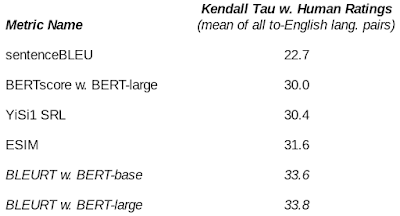

\
Article:https://ai.googleblog.com/2020/05/evaluating-natural-language-generation.html#:~:text=BLEURT%20is%20a%20novel,%20machine,ratings%20provided%20by%20the%20user \
GitHub: https://github.com/google-research/bleurt


## Encoding

**Sklearn : BOW**\
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [42]:
# # creating Bag-of-Words
# cv = CountVectorizer(max_df=0.9, binary=True)
# # fitting and transforming based on the references
# references = cv.fit_transform(train[['reference', 'translation']])
# # only transforming the translations
# translations = cv.transform(dev[['reference', 'translation']])

In [40]:
baseline_encoder = CountVectorizer()
names = ['train', 'dev', 'test']
for i,df in enumerate([train, dev, test]):
    for column in ['reference', 'translation']:
        encoded_df = names[i] + '_encoded_' + column
        if i == 0:
            vars()[encoded_df] = baseline_encoder.fit_transform(df[column]).todense()
        else:
            vars()[encoded_df] = baseline_encoder.transform(df[column]).todense()
            
    y_name = 'y_' + names[i].split('_')[0]
    vars()[y_name] = np.array(df['avg-score'])

In [41]:
dev_encoded_reference

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### 3.3. Model <a class="anchor" id="3.3."></a>

### 3.4. Evaluation <a class="anchor" id="3.4."></a>